In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from tqdm.auto import tqdm
from pandarallel import pandarallel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from collections import defaultdict

from wordcloud import WordCloud


In [2]:
# Use tqdm with apply to add a progress bar
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [6]:
data_path = 'data'
train_data_path = data_path + '/undersampled_bert_train_embeddings.pickle'

In [7]:
train_df = pd.read_pickle(train_data_path)

In [8]:
train_df.head()

,category,preprocessed_text_w_out_stemmer,labels,embeddings,product_id
0,ADSL Modemler,jh408a 8 port 1405-8g v3 gigabit switch,640,"[0.34650576, 0.17873834, 0.4821606, 0.27551544...",2573683
1,ADSL Modemler,modem 4port 150 mbps adsl2 dl-4312,640,"[-0.021621823, -0.28188184, 0.45389208, 0.3932...",45194791
2,ADSL Modemler,ubiquiti ubnt rocketdish 5g30 5ghz 30dbi acces...,640,"[0.5322421, 0.03842798, 0.061684053, 0.5888675...",2925807
3,ADSL Modemler,tenda d301 v2 yüksek hızlı - kesintisiz adsl2+...,640,"[0.0546572, -0.124499924, 0.2601985, 0.6263488...",169530918
4,ADSL Modemler,jetway f533 orange 6x intel glan firewall pc,640,"[0.6511229, -0.10714916, 0.025718188, 0.033977...",43936367


I will use Kmeans clustering to find 5 clusters

In [9]:
K=5
kmeans = KMeans(n_clusters=K, random_state=3)
kmeans.fit(np.asarray(train_df['embeddings'].to_list()))

In [10]:
kmeans.fit(np.asarray(train_df['embeddings'].to_list()))

/Users/berkedilekoglu/Desktop/trendyol/new_nlp_case_final/trendyol_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=3)

In [11]:
# Get the cluster assignments for each data point
cluster_labels = kmeans.labels_

# Get the cluster centers (centroids)
cluster_centers = kmeans.cluster_centers_

Lets visualize clusters and data points but I need to reduce dimensions into 2 for visualization

In [12]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Choose the number of components (e.g., 2 for 2D visualization)
data_reduced = pca.fit_transform(np.asarray(train_df['embeddings'].to_list()))

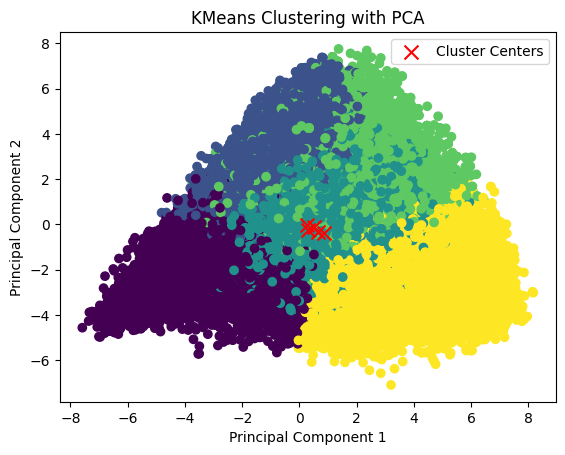

In [17]:
# Assuming data_reduced has two components (2D data)
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=cluster_labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=100, c='red', label='Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with PCA')
plt.legend()
plt.show()

In [24]:
# Collect sentences for each cluster
cluster_sentences = [[] for _ in range(K)]
for i, sentence in tqdm(enumerate(train_df['preprocessed_text_w_out_stemmer'].to_list())):
    cluster_sentences[cluster_labels[i]].append(sentence)

0it [00:00, ?it/s]

In [43]:
# Tokenize and preprocess sentences in each cluster
cluster_tokenized_sentences = []

cluster_tokenized_sentences = [" ".join(sentences) for sentences in cluster_sentences]

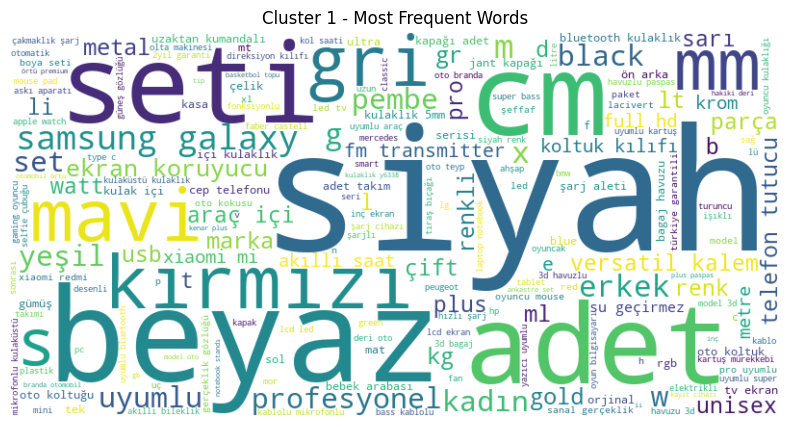

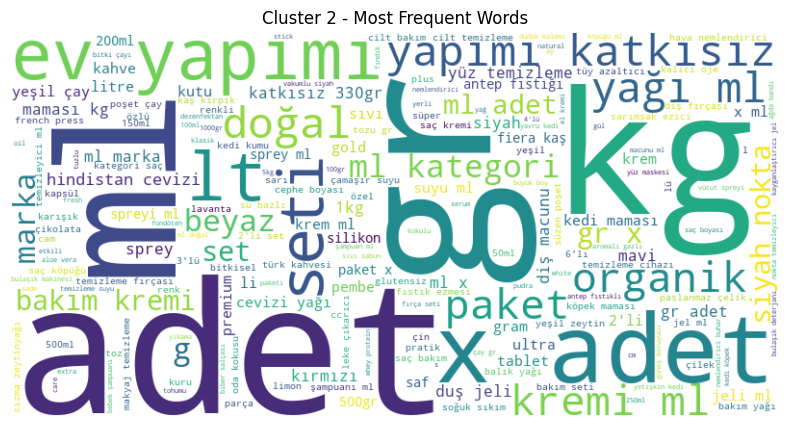

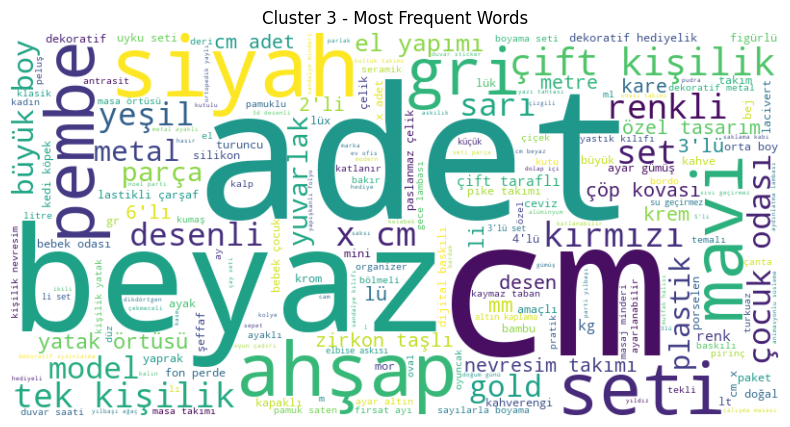

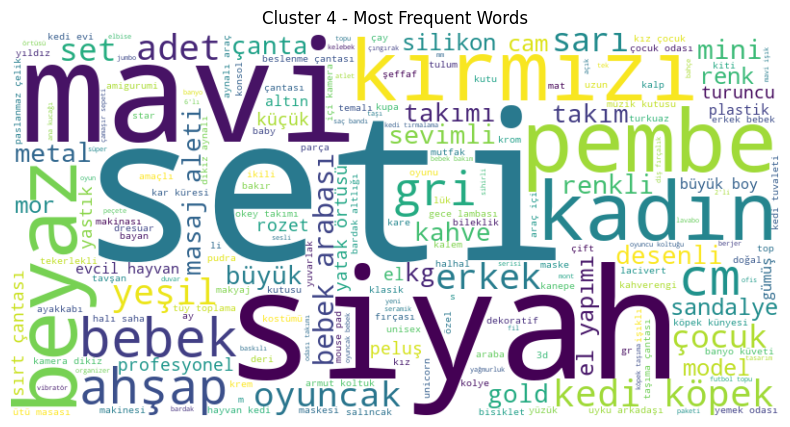

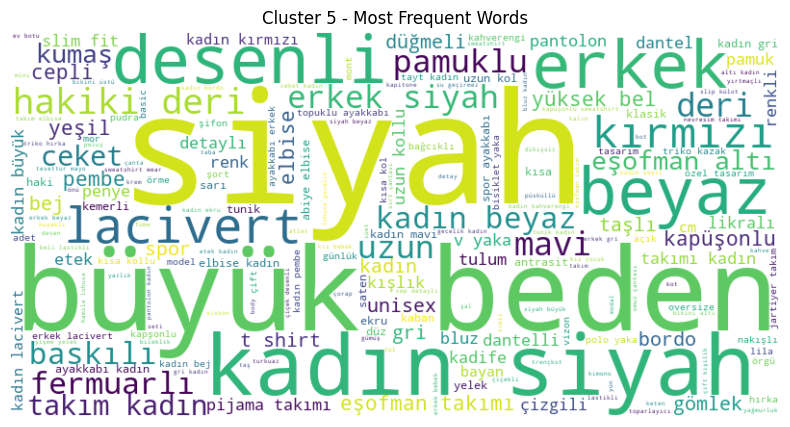

In [46]:
# Word cloud for each cluster
for i, cluster in enumerate(cluster_tokenized_sentences):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {i+1} - Most Frequent Words")
    plt.show()


In [47]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_df['preprocessed_text_w_out_stemmer'].to_list())

In [50]:
# Collect sentences for each cluster
cluster_sentences = defaultdict(list)
for i, sentence in enumerate(train_df['preprocessed_text_w_out_stemmer'].to_list()):
    cluster_sentences[cluster_labels[i]].append(sentence)

In [52]:
# Calculate word frequencies for each cluster (document)
word_frequencies = {}
for cluster, sentences in cluster_sentences.items():
    cluster_text = " ".join(sentences)
    X_cluster = vectorizer.transform([cluster_text])
    word_counts = X_cluster.toarray()[0]
    feature_names = vectorizer.get_feature_names_out()
    word_frequencies[cluster] = {word: count for word, count in zip(feature_names, word_counts) if count > 0}


In [55]:
# Get the most frequent words for each cluster (document)
num_most_frequent = 20  # Choose the number of most frequent words you want to display
most_frequent_words = {}
for cluster, frequencies in word_frequencies.items():
    sorted_frequencies = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)[:num_most_frequent]
    most_frequent_words[cluster] = [word for word, count in sorted_frequencies]

In [56]:
# Print the most frequent words for each cluster (document)
for cluster, words in most_frequent_words.items():
    print(f"Cluster {cluster+1}: {', '.join(words)}")

Cluster 1: uyumlu, siyah, seti, oto, mm, 10, usb, pro, bluetooth, adet, ekran, beyaz, kalem, led, makinesi, 12, şarj, erkek, model, set
Cluster 4: bebek, kedi, seti, köpek, oyuncak, çantası, çocuk, kadın, pembe, mavi, erkek, takımı, ahşap, siyah, kırmızı, beyaz, oyun, cm, yeşil, gri
Cluster 3: cm, adet, seti, beyaz, ahşap, dekoratif, takımı, kişilik, bebek, desenli, çift, metal, siyah, set, li, çocuk, lü, renk, yatak, mutfak
Cluster 5: kadın, siyah, erkek, beden, büyük, takım, detaylı, yaka, deri, ayakkabı, desenli, elbise, beyaz, uzun, lacivert, takımı, eşofman, gri, pantolon, bel
Cluster 2: ml, gr, adet, kg, 500, yağı, 100, saç, bakım, kremi, 50, 250, paket, lt, 200, temizleme, doğal, li, yüz, 150


In [ ]:
#Cluster 1: Elektronik
#Cluster 2: Bakım /Kozmetik
#Cluster 3: Yapı Market / Ev / Mobilya
#Cluster 4: Bebek / Çocuk
#Cluster 5: Giyim

In [17]:
cluster_label_map = {0:'Elektronik',1:'Bakım /Kozmetik',2:'Yapı Market / Ev / Mobilya',3:'Bebek / Çocuk',4:'Giyim'}

In [18]:
label_list = [cluster_label_map[cluster] for cluster in cluster_labels]

In [20]:
train_df['category_clustered_predictions'] = label_list
train_df.head()

,category,preprocessed_text_w_out_stemmer,labels,embeddings,product_id,category_clustered_predictions
0,ADSL Modemler,jh408a 8 port 1405-8g v3 gigabit switch,640,"[0.34650576, 0.17873834, 0.4821606, 0.27551544...",2573683,Elektronik
1,ADSL Modemler,modem 4port 150 mbps adsl2 dl-4312,640,"[-0.021621823, -0.28188184, 0.45389208, 0.3932...",45194791,Elektronik
2,ADSL Modemler,ubiquiti ubnt rocketdish 5g30 5ghz 30dbi acces...,640,"[0.5322421, 0.03842798, 0.061684053, 0.5888675...",2925807,Elektronik
3,ADSL Modemler,tenda d301 v2 yüksek hızlı - kesintisiz adsl2+...,640,"[0.0546572, -0.124499924, 0.2601985, 0.6263488...",169530918,Elektronik
4,ADSL Modemler,jetway f533 orange 6x intel glan firewall pc,640,"[0.6511229, -0.10714916, 0.025718188, 0.033977...",43936367,Elektronik


In [21]:
train_df.drop(['labels','embeddings'], axis=1).reset_index(drop=True).to_csv('partb_category_preds.csv')